wGAN using **Wasserstein distance** for loss evaluation.  
Take the **GP(Gradient Penalty)** method so that the discriminator does not learn too fast.

In [1]:
import cv2
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-06-21 12:14:53.863999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 12:14:54.549121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(6,8), rows=1, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        img = cv2.imread(imspaths[i])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.imshow(img)
    f.tight_layout()

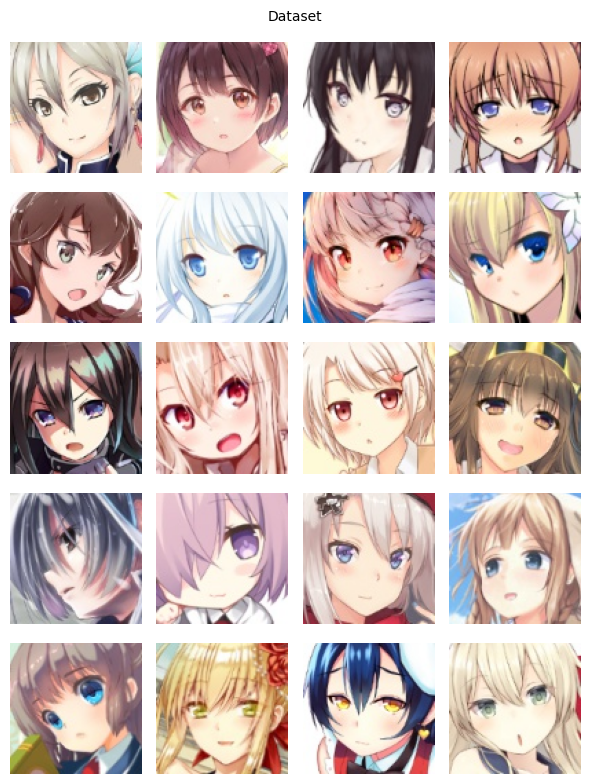

In [3]:
plots_from_files(imspaths = list(paths.list_images('./faces'))[0:20], rows = 5, maintitle = 'Dataset')

In [4]:
images = paths.list_images('./faces')

dataset = []
for imgpath in images:
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (64, 64))
    dataset.append(img/255.0)

In [5]:
np.array(dataset).shape

(71314, 64, 64, 3)

In [6]:
BS = 64

dataset = tf.data.Dataset.from_tensor_slices(np.array(dataset))
dataset = dataset.shuffle(buffer_size=1024).batch(BS)

2023-06-21 12:22:47.175564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-06-21 12:22:47.178251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29443 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-06-21 12:22:47.180810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 29441 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-06-21 12:22:47.183558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38370 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [7]:
tf.keras.backend.clear_session()

In [8]:
Noise_Dim = 150

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(Noise_Dim,)),
    layers.Dense(4*4*256),
    layers.BatchNormalization(),
    layers.Reshape(target_shape=(4, 4, 256)),
    layers.Conv2DTranspose(512, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, 3, activation='tanh', strides=2, padding='same')
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              618496    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        1180160   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                        

In [9]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 3)),
    layers.Conv2D(256, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Conv2D(128, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Conv2D(4, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(16, activation='LeakyReLU'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 4)           4612      
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [10]:
optG = keras.optimizers.RMSprop(learning_rate=0.00005)
optD = keras.optimizers.RMSprop(learning_rate=0.00005)

### wGAN Loss
##### discriminator loss
discriminator計算(真圖片=真)和(生成圖片=真)的分數，兩者之差就是w distance，為了區分真實圖片(r)和生成圖片(g)，要
maximize這個距離，得 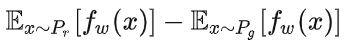
因為要maximize，所以取負號再做gradient descent  
結論: **tf.reduce_mean(fake) - tf.reduce_mean(real)**
##### geneator loss
generator要讓(生成圖片=真)的分數越高越好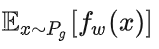
因為要maximize，所以取負號再做gradient descent  
結論: **- tf.reduce_mean(real)**

### Gradient Penalty
因上述discriminator需要滿足1-Lipschitz，約束gradient update，限制discriminator的能力，不要讓discriminator變太強
##### clip
原本的作法是把weight clip在一定的範圍內。
但可能最後會出現weight都趨近於bound的情況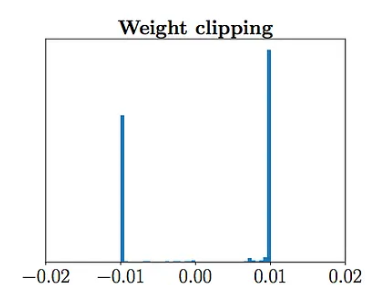
所以出現gradient penalty的作法
##### gradient penatly
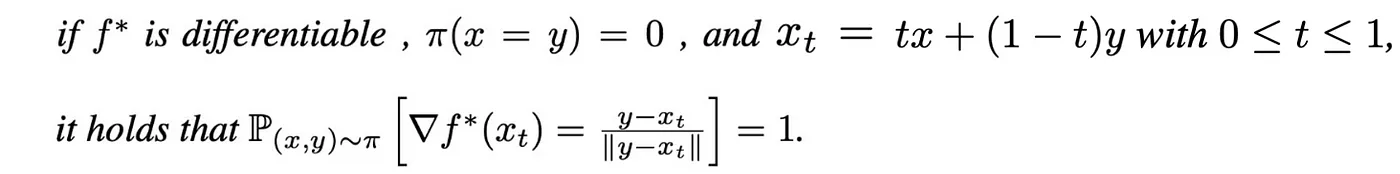
把(真、生成圖片混和)對(生成圖片)取gradient的norm要越接近1，越可以符合1-Lipschitz
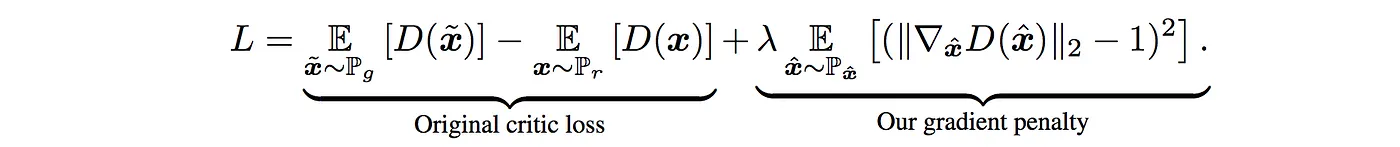
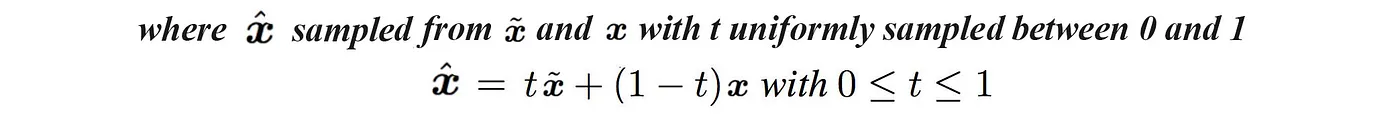



In [11]:
## train disciminator to classify original img and gerenated img
LAMBDA = 20

@tf.function
def trainDStep(data):
    
    with tf.GradientTape() as tape:
        
        real  = tf.cast(data, tf.float32)
        Noise = tf.random.normal(shape=(real.get_shape()[0], Noise_Dim))
        fake  = generator(Noise)
        t     = tf.random.uniform(shape=[real.get_shape()[0], 1, 1, 1], minval=0, maxval=1)
        interpolation = t * tf.cast(real, tf.float32) + (1.0 - t) * fake
        
        # calculate gp
        with tf.GradientTape() as gptape:    
            gptape.watch(interpolation)
            interpolation_pred = discriminator(interpolation)
        grads = gptape.gradient(interpolation_pred, interpolation)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = LAMBDA * tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator(fake)
        real_pred = discriminator(real)
        discriminatorLoss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gradient_penalty
        
    discriminator_grad = tape.gradient(discriminatorLoss, discriminator.trainable_variables)
    optD.apply_gradients(zip(discriminator_grad, discriminator.trainable_variables))
    
    return{
        'discriminator_loss' : discriminatorLoss
    }

In [12]:
## train generator make fake img
@tf.function
def trainGStep(data):
    BS = data.get_shape()[0]
    Noise = tf.random.normal(shape=(BS, Noise_Dim))
 
    with tf.GradientTape() as tape:
        fake_pred = discriminator(generator(Noise))
        generatorLoss = -tf.reduce_mean(fake_pred)
    grad = tape.gradient(generatorLoss, generator.trainable_variables)
    optG.apply_gradients(zip(grad, generator.trainable_variables))
    
    return{
        'generator_loss' : generatorLoss
    }

In [13]:
def plot_result(model):
    images = model(np.random.normal(size=(5*5, Noise_Dim)))
    
    plt.figure(figsize=(5,5))
    for i, image in enumerate(images):
        image = image.numpy()
        
        # min-max normalization
        min_vals = np.min(image, axis=(0,1,2))
        max_vals = np.max(image, axis=(0,1,2))
        image = (image - min_vals) / (max_vals - min_vals)
        
        plt.subplot(5, 5, i+1)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

epoch:0        DiscriminatorLoss:-0.28        GeneratorLoss:3.21


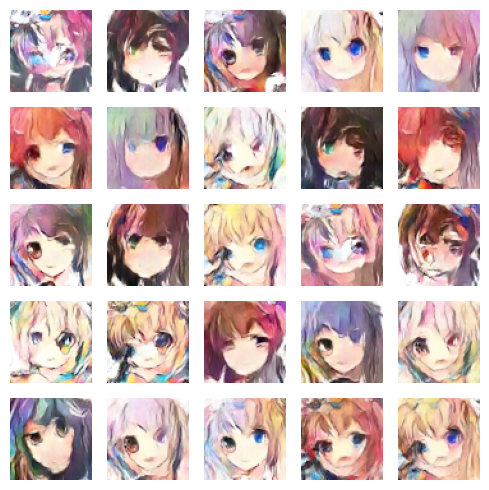

epoch:1        DiscriminatorLoss:-0.29        GeneratorLoss:2.73
epoch:2        DiscriminatorLoss:-0.30        GeneratorLoss:2.50
epoch:3        DiscriminatorLoss:-0.30        GeneratorLoss:2.64
epoch:4        DiscriminatorLoss:-0.31        GeneratorLoss:2.86
epoch:5        DiscriminatorLoss:-0.31        GeneratorLoss:2.60


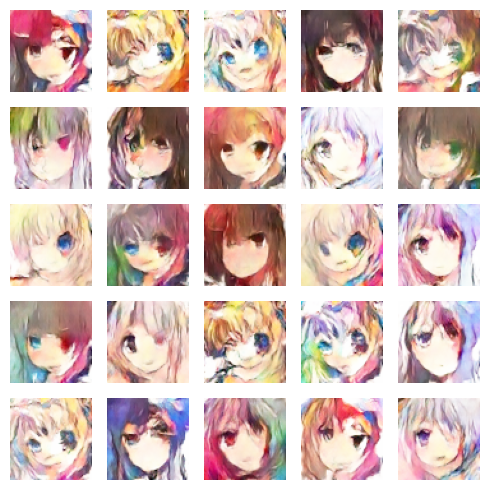

epoch:6        DiscriminatorLoss:-0.32        GeneratorLoss:3.12
epoch:7        DiscriminatorLoss:-0.32        GeneratorLoss:3.55
epoch:8        DiscriminatorLoss:-0.32        GeneratorLoss:3.39
epoch:9        DiscriminatorLoss:-0.34        GeneratorLoss:2.95
epoch:10        DiscriminatorLoss:-0.34        GeneratorLoss:2.55


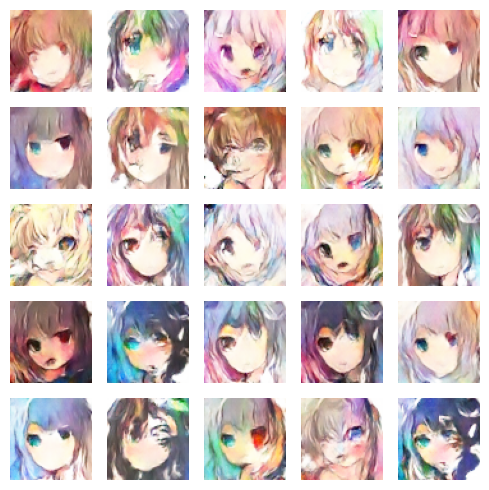

epoch:11        DiscriminatorLoss:-0.34        GeneratorLoss:1.94
epoch:12        DiscriminatorLoss:-0.35        GeneratorLoss:1.98
epoch:13        DiscriminatorLoss:-0.36        GeneratorLoss:2.69
epoch:14        DiscriminatorLoss:-0.36        GeneratorLoss:2.98
epoch:15        DiscriminatorLoss:-0.36        GeneratorLoss:3.38


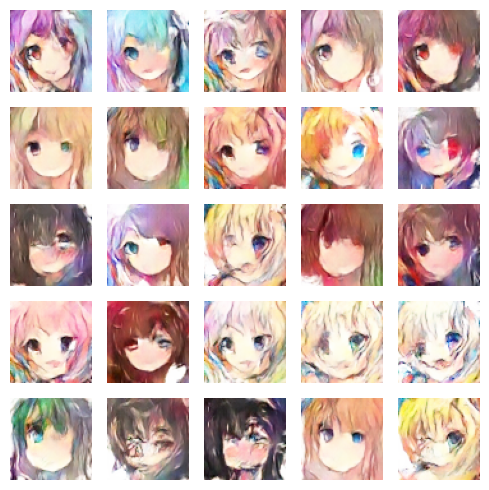

epoch:16        DiscriminatorLoss:-0.35        GeneratorLoss:3.81
epoch:17        DiscriminatorLoss:-0.36        GeneratorLoss:4.13
epoch:18        DiscriminatorLoss:-0.36        GeneratorLoss:4.36
epoch:19        DiscriminatorLoss:-0.36        GeneratorLoss:3.62
epoch:20        DiscriminatorLoss:-0.35        GeneratorLoss:3.21


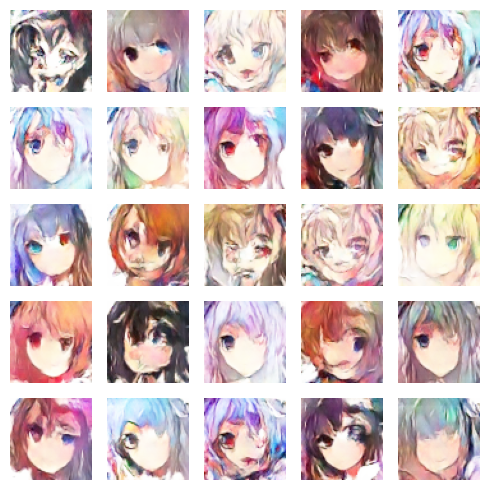

epoch:21        DiscriminatorLoss:-0.35        GeneratorLoss:2.96
epoch:22        DiscriminatorLoss:-0.36        GeneratorLoss:2.38
epoch:23        DiscriminatorLoss:-0.35        GeneratorLoss:4.42
epoch:24        DiscriminatorLoss:-0.33        GeneratorLoss:3.53
epoch:25        DiscriminatorLoss:-0.33        GeneratorLoss:2.89


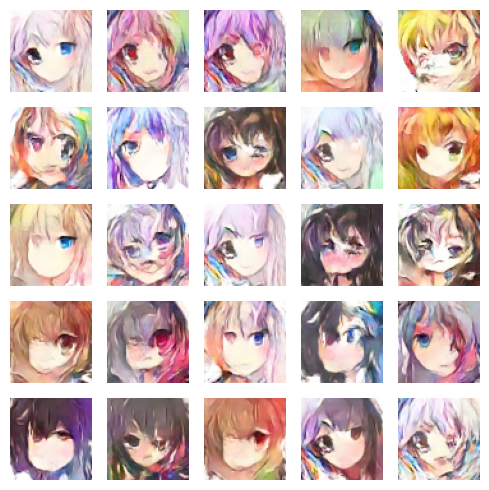

epoch:26        DiscriminatorLoss:-0.34        GeneratorLoss:2.12
epoch:27        DiscriminatorLoss:-0.33        GeneratorLoss:1.40
epoch:28        DiscriminatorLoss:-0.33        GeneratorLoss:2.21
epoch:29        DiscriminatorLoss:-0.33        GeneratorLoss:3.03
epoch:30        DiscriminatorLoss:-0.32        GeneratorLoss:4.04


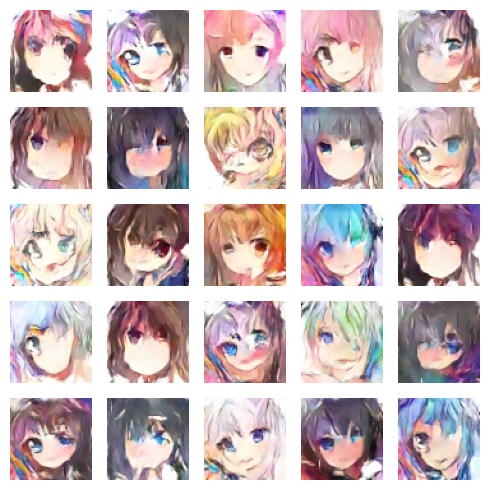

epoch:31        DiscriminatorLoss:-0.32        GeneratorLoss:3.51
epoch:32        DiscriminatorLoss:-0.32        GeneratorLoss:2.53
epoch:33        DiscriminatorLoss:-0.33        GeneratorLoss:3.07
epoch:34        DiscriminatorLoss:-0.32        GeneratorLoss:2.44
epoch:35        DiscriminatorLoss:-0.33        GeneratorLoss:3.39


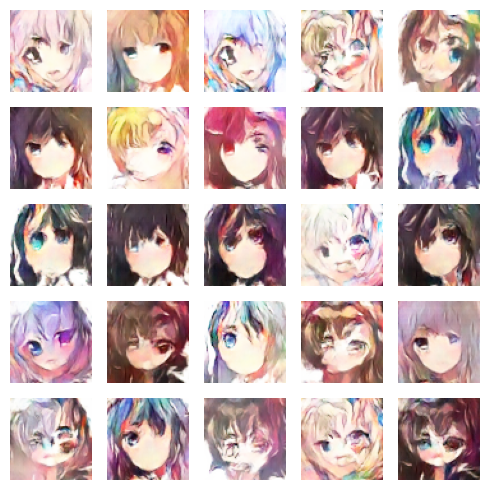

epoch:36        DiscriminatorLoss:-0.31        GeneratorLoss:2.61
epoch:37        DiscriminatorLoss:-0.31        GeneratorLoss:2.25
epoch:38        DiscriminatorLoss:-0.31        GeneratorLoss:2.67
epoch:39        DiscriminatorLoss:-0.30        GeneratorLoss:2.18
epoch:40        DiscriminatorLoss:-0.30        GeneratorLoss:2.94


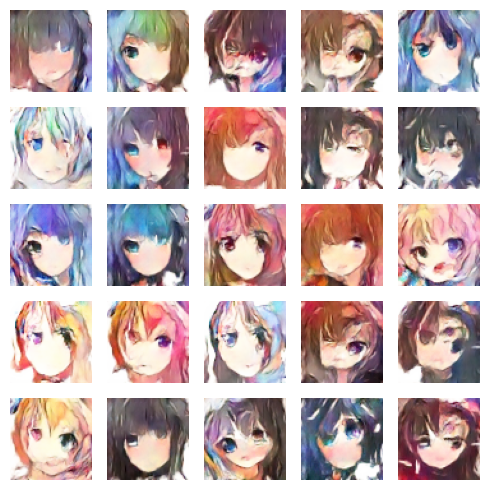

epoch:41        DiscriminatorLoss:-0.29        GeneratorLoss:3.19
epoch:42        DiscriminatorLoss:-0.29        GeneratorLoss:3.48
epoch:43        DiscriminatorLoss:-0.28        GeneratorLoss:3.04
epoch:44        DiscriminatorLoss:-0.29        GeneratorLoss:2.60
epoch:45        DiscriminatorLoss:-0.29        GeneratorLoss:2.20


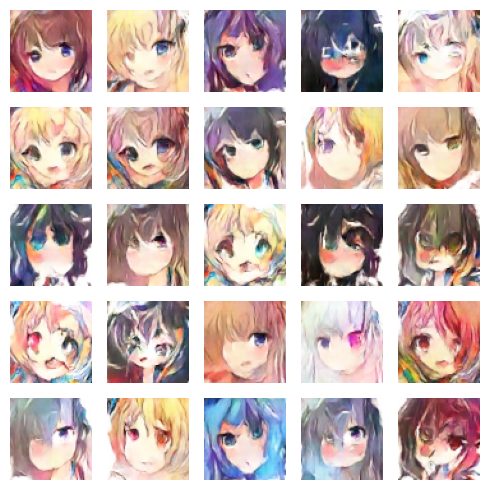

epoch:46        DiscriminatorLoss:-0.28        GeneratorLoss:2.93
epoch:47        DiscriminatorLoss:-0.28        GeneratorLoss:3.54
epoch:48        DiscriminatorLoss:-0.28        GeneratorLoss:4.03
epoch:49        DiscriminatorLoss:-0.28        GeneratorLoss:2.95


In [17]:
for epoch in range(50):
    dLossSum = 0
    gLossSum = 0
    dcnt = 0
    gcnt = 0
    
    for batch in dataset:

        dLoss = trainDStep(batch)
        dLossSum += dLoss['discriminator_loss']
        dcnt += 1
        
        if dcnt % 3 == 0: 
            gLoss = trainGStep(batch)
            gLossSum += gLoss['generator_loss']
            gcnt += 1
        
    print(f'epoch:{epoch}        DiscriminatorLoss:{dLossSum/dcnt :.2f}        GeneratorLoss:{gLossSum/gcnt :.2f}')
    
    if epoch % 5 == 0:
        plot_result(generator)

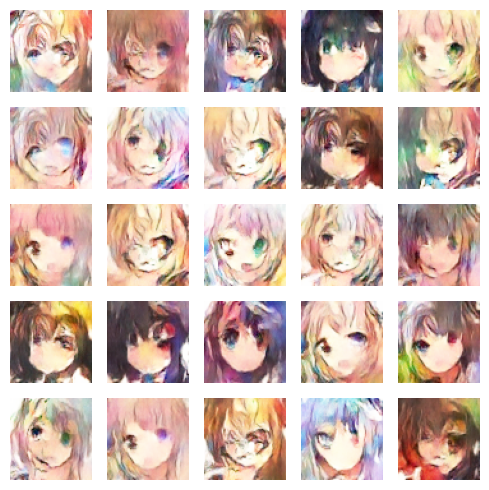

In [15]:
plot_result(generator)